In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
scope = "user-library-read"
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

In [3]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

In [4]:
infile = open('pickled_files/df.pickle','rb')
df = pickle.load(infile)
infile.close()
df.set_index('id', inplace = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5268 entries, 1gyee1JuFFiP476LQpRMYU to 0SfpnyHLyrUlBTgGxgmKVR
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      5268 non-null   float64
 1   energy            5268 non-null   float64
 2   key               5268 non-null   object 
 3   loudness          5268 non-null   float64
 4   mode              5268 non-null   object 
 5   speechiness       5268 non-null   float64
 6   acousticness      5268 non-null   float64
 7   instrumentalness  5268 non-null   float64
 8   liveness          5268 non-null   float64
 9   valence           5268 non-null   float64
 10  tempo             5268 non-null   float64
 11  duration_ms       5268 non-null   float64
 12  time_signature    5268 non-null   object 
 13  genre             5268 non-null   object 
dtypes: float64(10), object(4)
memory usage: 617.3+ KB


In [6]:
categorical_columns = list(df.drop('genre', axis = 1).select_dtypes('object').columns)
numerical_columns = list(df.drop('genre', axis = 1).select_dtypes(exclude = 'object').columns)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['genre'], axis=1),
                                                    df.genre,
                                                   random_state=9)

In [8]:
y_train.value_counts(normalize=True)

hip-hop      0.418881
alt-metal    0.240445
rock         0.209567
pop          0.131106
Name: genre, dtype: float64

In [9]:
def evaluation_report(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"F1 Score: {f1_score(y_test, model.predict(X_test), average = 'macro')}")
    plot_confusion_matrix(model, X_test, y_test, cmap='GnBu',xticks_rotation='vertical')

**First Simple Model**

In [10]:
lr = LogisticRegression(random_state=9)
ss = StandardScaler()
lr.fit(ss.fit_transform(X_train), y_train)

LogisticRegression(random_state=9)

In [11]:
lr.classes_

array(['alt-metal', 'hip-hop', 'pop', 'rock'], dtype=object)

Training
F1 Score: 0.6263683742501592


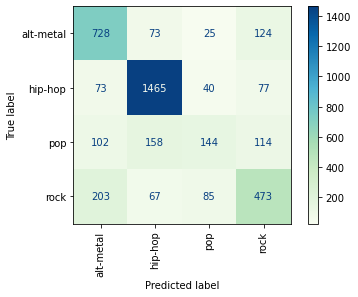

In [12]:
print('Training')
evaluation_report(lr, ss.fit_transform(X_train), y_train)

Testing
F1 Score: 0.6399862672407418


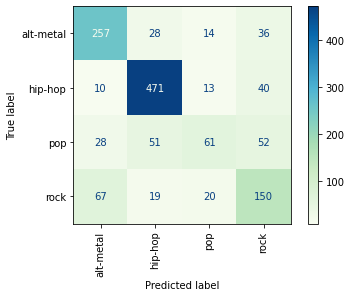

In [13]:
print('Testing')
evaluation_report(lr, ss.transform(X_test), y_test)

<hl>

In [14]:
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import GridSearchCV

In [15]:
#Create pipelines
numerical_pipeline = imbpipeline(verbose=False,steps=[
                                ('ss', StandardScaler())
                            ])

categorical_pipeline = imbpipeline(verbose=False,steps=[
                            ('ohe', OneHotEncoder(drop='first',
                                                 sparse=False,))
                            ])

col_trans = ColumnTransformer(verbose=False,transformers=[
    ('numerical', numerical_pipeline, numerical_columns),
    ('categorical', categorical_pipeline, categorical_columns)
])

col_ohe_solo = ColumnTransformer(verbose=False,transformers=[
    ('categorical', categorical_pipeline, categorical_columns)
])


<hl>

**Second Model**

In [16]:
pipe_log = imbpipeline(verbose=False, steps=[
    ('col_trans', col_trans),
    ('lr', LogisticRegression(max_iter = 10000, random_state=9, class_weight='balanced'))
])

param_grid = [
    {
     'lr__penalty' : ['l1','l2'],
     'lr__C' : [.75,.5,.25],
     'lr__solver' : ['saga','sag', 'lbfgs']
    }, 
]

gs_lr = GridSearchCV(pipe_log, param_grid = param_grid, 
                        scoring = 'f1_macro', n_jobs=-1, verbose=True)
gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   28.4s finished


GridSearchCV(estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['danceability',
                                                                          'energy',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'acousticness',
                                                                          'instrumentalness',
                                                                          'liveness',
                                   

In [17]:
gs_lr.best_params_

{'lr__C': 0.5, 'lr__penalty': 'l1', 'lr__solver': 'saga'}

Training
F1 Score: 0.6458631282387632


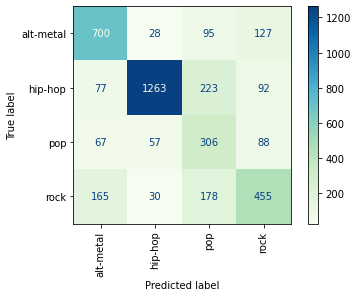

In [18]:
print('Training')
evaluation_report(gs_lr, X_train, y_train)

Testing
F1 Score: 0.6480539045484064


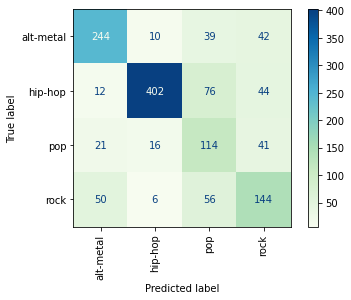

In [19]:
print('Testing')
evaluation_report(gs_lr, X_test, y_test)

In [20]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

In [21]:
ohe = OneHotEncoder(drop='first', sparse=False)
sm = SMOTE(random_state = 9)


In [30]:
train_ohe = ohe.fit_transform(X_train[categorical_columns])
test_ohe = ohe.transform(X_test[categorical_columns])
train_ohe = X_train[numerical_columns].reset_index().join(pd.DataFrame(train_ohe)).set_index('id')

train_sm = sm.fit_resample(train_ohe, y_train)
test_ohe = X_test[numerical_columns].reset_index().join(pd.DataFrame(test_ohe)).set_index('id')

**Model 3**

In [31]:
from xgboost import XGBClassifier

In [32]:
xgbc = XGBClassifier(random_state = 9, n_jobs = -1)
params = {
    'max_depth': [1,2],
    'learning_rate': [.1,.05,.01,.005],
    'n_estimators': range(180,220,20),
    'booster': ['gbtree', 'dart']
}
#Run gridsearch
gs_xgbc = GridSearchCV(xgbc, param_grid=params, scoring='f1_macro', n_jobs =-1 )

In [33]:
gs_xgbc.fit(train_sm[0], train_sm[1])

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=9,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=Non

In [34]:
gs_xgbc.best_params_

{'booster': 'gbtree',
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 200}

Training
F1 Score: 0.7890777792693433


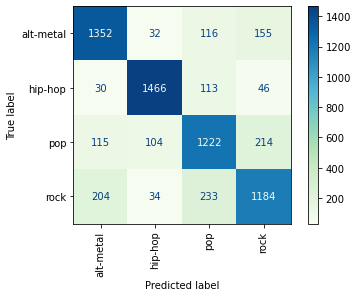

In [35]:
print('Training')
evaluation_report(gs_xgbc, train_sm[0], train_sm[1])

Testing
F1 Score: 0.6793578047998373


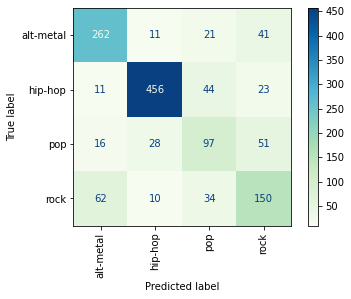

In [36]:
print('Testing')
evaluation_report(gs_xgbc, test_ohe, y_test)

**Model 4**

In [37]:
gbclf = GradientBoostingClassifier(random_state = 9)

param_grid = [
    {
     'n_estimators' : [50,75,100,125],
     'learning_rate' : [.05, .1, .15, .2],
     'max_depth': [1,2]
    }, 
]

gs_gbclf = GridSearchCV(gbclf, param_grid = param_grid, 
                        scoring = 'f1_macro', n_jobs=-1, verbose=True)
gs_gbclf.fit(train_sm[0], train_sm[1])

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  3.9min finished


GridSearchCV(estimator=GradientBoostingClassifier(random_state=9), n_jobs=-1,
             param_grid=[{'learning_rate': [0.05, 0.1, 0.15, 0.2],
                          'max_depth': [1, 2],
                          'n_estimators': [50, 75, 100, 125]}],
             scoring='f1_macro', verbose=True)

In [38]:
gs_gbclf.best_params_

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 125}

Training
F1 Score: 0.8267180681715205


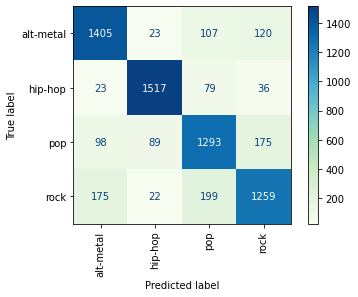

In [39]:
print('Training')
evaluation_report(gs_gbclf, train_sm[0], train_sm[1])

Testing
F1 Score: 0.6899248415535542


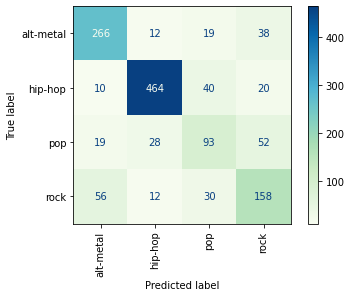

In [40]:
print('Testing')
evaluation_report(gs_gbclf, test_ohe, y_test)

**Model 5**

In [41]:
lr_col_trans = ColumnTransformer(verbose=False,transformers=[
    ('numerical', numerical_pipeline, numerical_columns),
    ('categorical', categorical_pipeline, categorical_columns)
])

lr_train_transf = lr_col_trans.fit_transform(X_train)
lr_test_transf = lr_col_trans.transform(X_test)

In [42]:
lr2 = LogisticRegression(max_iter = 10000, random_state=9, class_weight='balanced')

param_grid = [
    {
     'penalty' : ['l1','l2'],
     'C' : [.75,.5,.25],
     'solver' : ['saga','sag', 'lbfgs']
    }, 
]

gs_lr2 = GridSearchCV(lr2, param_grid = param_grid, 
                        scoring = 'f1_macro', n_jobs=-1, verbose=True)
gs_lr2.fit(lr_train_transf, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   43.1s finished


GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, random_state=9),
             n_jobs=-1,
             param_grid=[{'C': [0.75, 0.5, 0.25], 'penalty': ['l1', 'l2'],
                          'solver': ['saga', 'sag', 'lbfgs']}],
             scoring='f1_macro', verbose=True)

In [43]:
gs_lr2.best_params_

{'C': 0.5, 'penalty': 'l1', 'solver': 'saga'}

Training
F1 Score: 0.6458631282387632


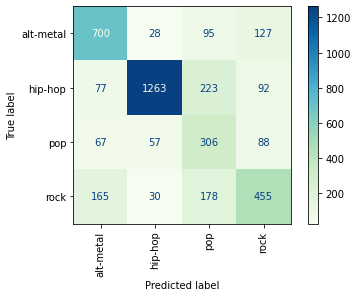

In [44]:
print('Training')
evaluation_report(gs_lr2, lr_train_transf, y_train)

Testing
F1 Score: 0.6480539045484064


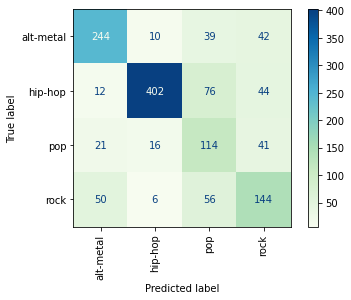

In [45]:
print('Testing')
evaluation_report(gs_lr2, lr_test_transf, y_test)

**Model 6**

In [46]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [47]:
classes_weights

array([0.59682779, 1.19293478, 1.19293478, ..., 0.59682779, 1.90685328,
       0.59682779])

In [48]:
xgbc2 = XGBClassifier(random_state = 9, n_jobs = -1)
params = {
    'max_depth': [1,2],
    'learning_rate': [.1,.05,.01,.005],
    'n_estimators': range(180,220,20),
    'booster': ['gbtree','dart'],
#     'weight': classes_weights
}
#Run gridsearch
gs_xgbc2 = GridSearchCV(xgbc2, param_grid=params, scoring='f1_macro', n_jobs =-1 )
gs_xgbc2.fit(train_ohe, y_train, sample_weight=classes_weights)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=9,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=Non

In [49]:
gs_xgbc2.best_params_

{'booster': 'gbtree',
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 200}

Training
F1 Score: 0.7466880871196648


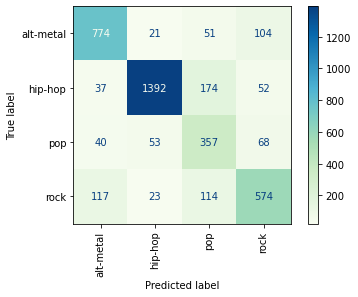

In [50]:
print('Training')
evaluation_report(gs_xgbc2, train_ohe, y_train)

Testing
F1 Score: 0.6893463359035795


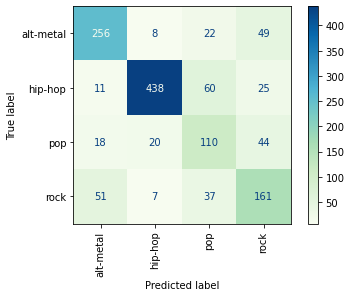

In [51]:
print('Testing')
evaluation_report(gs_xgbc2, test_ohe, y_test)

{'booster': 'gbtree',
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 200}

Training
F1 Score: 0.7466880871196648

Testing
F1 Score: 0.6893463359035795

In [52]:
best_model = gs_xgbc2

In [53]:
X_final = df.drop('genre', axis = 1)
y_final = df.genre

In [57]:
final_ohe = ohe.transform(X_final[categorical_columns])
final_ohe = X_final[numerical_columns].reset_index().join(pd.DataFrame(final_ohe)).set_index('id')

In [58]:
final_ohe

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,6,7,8,9,10,11,12,13,14,15
id,,,,,,,,,,,,,,,,,,,,,
1gyee1JuFFiP476LQpRMYU,0.509,0.843,-3.318,0.0488,0.000671,0.000803,0.3480,0.332,140.055,238400.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7HgQTacsIKMUiElM725aav,0.644,0.287,-14.072,0.0257,0.283000,0.005800,0.0705,0.315,103.983,218893.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
639p4iSG1S0lXJ6RJJ6jLN,0.478,0.940,-3.888,0.1250,0.000045,0.002530,0.1310,0.310,164.881,196133.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
64fzn2ewOdSH57wrxTPGov,0.533,0.320,-8.819,0.0316,0.731000,0.000017,0.1540,0.291,98.036,226160.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3ivJymJnoceuUUe7wTP6m4,0.598,0.856,-6.204,0.3060,0.219000,0.000000,0.2910,0.779,173.929,272627.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0pNMYo9MXmyyR9Fp9HwiBT,0.638,0.863,-5.891,0.3090,0.023000,0.000000,0.6280,0.516,153.954,247267.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4MFCXniy7I8tj0GXtf3wgC,0.638,0.924,-3.887,0.0360,0.002050,0.000175,0.1490,0.530,111.995,263787.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3tkbjyAmQnGsD52Rn8TCX8,0.772,0.861,-2.389,0.0898,0.135000,0.000742,0.0640,0.424,133.918,204160.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [59]:
best_model.predict(final_ohe)

array(['alt-metal', 'rock', 'alt-metal', ..., 'pop', 'hip-hop', 'pop'],
      dtype=object)

F1 Score: 0.7322209266783103


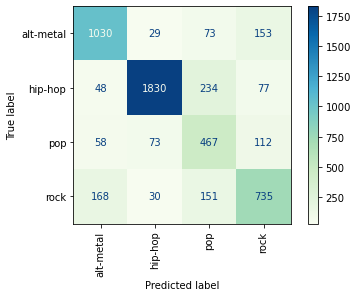

In [60]:
evaluation_report(best_model, final_ohe, y_final)